<a href="https://colab.research.google.com/github/SwapnilMergu/Transformers-GAN/blob/main/n_n_bonus_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from transformers import pipeline

#Initialize QA pipeline
qa_pipeline = pipeline("question-answering")

#Context and question
context = "Charles Babbage is considered the father of the computer because of his work on the Analytical Engine."
question = "Who is considered the father of the computer?"
#Perform QA
result = qa_pipeline(question=question, context=context)
print("Basic Pipeline Result:\n", result)

Basic Pipeline Result:
 {'score': 0.9978699684143066, 'start': 0, 'end': 15, 'answer': 'Charles Babbage'}


In [16]:
#Load QA pipeline with a custom model

from transformers import pipeline

#Loading custom model
custom_qa = pipeline("question-answering", model="deepset/roberta-base-squad2")

#Context and question
context = "Charles Babbage is considered the father of the computer because of his work on the Analytical Engine."
question = "Who is considered the father of the computer?"

#Perform QA with custom model
custom_result = custom_qa(question=question, context=context)
print("\nCustom Model Result:\n", custom_result)



Custom Model Result:
 {'score': 0.9640105962753296, 'start': 0, 'end': 15, 'answer': 'Charles Babbage'}


In [20]:
#New context and questions

from transformers import pipeline

my_context = (
    "The Pokiri movie featuring Mahesh Babu as the main lead was released in 2006."
)
question1 = "Who was the main lead in Pokiri movie?"
question2 = "When was the Pokiri movie relesed?"

#Loading custom model
custom_qa = pipeline("question-answering", model="deepset/roberta-base-squad2")

#Ask using custom model
answer1 = custom_qa(question=question1, context=my_context)
answer2 = custom_qa(question=question2, context=my_context)

print("\nYour Own Example Results:")
print("Q1:", question1)
print("A1:", answer1)

print("Q2:", question2)
print("A2:", answer2)



Your Own Example Results:
Q1: Who was the main lead in Pokiri movie?
A1: {'score': 0.9832262396812439, 'start': 27, 'end': 38, 'answer': 'Mahesh Babu'}
Q2: When was the Pokiri movie relesed?
A2: {'score': 0.9479328393936157, 'start': 72, 'end': 76, 'answer': '2006'}


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.72MB/s]


Epoch 1/50 | D Loss: 0.3737 | G Loss: 1.0450


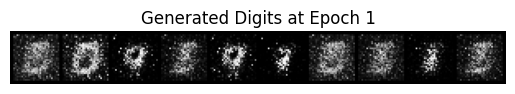

Epoch 2/50 | D Loss: 0.3145 | G Loss: 1.0839
Epoch 3/50 | D Loss: 0.3254 | G Loss: 1.4758
Epoch 4/50 | D Loss: 0.2551 | G Loss: 1.7087
Epoch 5/50 | D Loss: 0.3050 | G Loss: 1.2387
Epoch 6/50 | D Loss: 0.3389 | G Loss: 1.0344
Epoch 7/50 | D Loss: 0.4044 | G Loss: 2.4348
Epoch 8/50 | D Loss: 0.4438 | G Loss: 0.6771
Epoch 9/50 | D Loss: 0.3539 | G Loss: 2.5010
Epoch 10/50 | D Loss: 0.2823 | G Loss: 1.8062
Epoch 11/50 | D Loss: 0.2893 | G Loss: 1.1137
Epoch 12/50 | D Loss: 0.3129 | G Loss: 1.6558
Epoch 13/50 | D Loss: 0.3569 | G Loss: 2.5397
Epoch 14/50 | D Loss: 0.1871 | G Loss: 1.6260
Epoch 15/50 | D Loss: 0.2209 | G Loss: 2.1219
Epoch 16/50 | D Loss: 0.2787 | G Loss: 1.3325
Epoch 17/50 | D Loss: 0.7556 | G Loss: 4.5940
Epoch 18/50 | D Loss: 0.4510 | G Loss: 3.3409
Epoch 19/50 | D Loss: 0.7408 | G Loss: 0.4006
Epoch 20/50 | D Loss: 0.2261 | G Loss: 1.5857
Epoch 21/50 | D Loss: 0.3068 | G Loss: 1.4287
Epoch 22/50 | D Loss: 0.2431 | G Loss: 3.3775
Epoch 23/50 | D Loss: 0.2407 | G Loss: 2.5

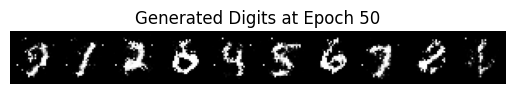

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 100
num_classes = 10
image_size = 28
channels = 1
batch_size = 128
epochs = 50
lr = 0.0002

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

# Generator
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_embed(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(-1, 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(784 + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        c = self.label_embed(labels)
        x = torch.cat([img_flat, c], 1)
        return self.model(x)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        imgs, labels = imgs.to(device), labels.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = G(z, gen_labels)
        g_loss = adversarial_loss(D(gen_imgs, gen_labels), real)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(D(imgs, labels), real)
        fake_loss = adversarial_loss(D(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Show generated digits at specific epochs
    if epoch in [0, 49, 99] or epoch == epochs - 1:
        z = torch.randn(10, latent_dim).to(device)
        labels = torch.arange(0, 10).to(device)
        gen_imgs = G(z, labels).cpu().detach()
        grid = make_grid(gen_imgs, nrow=10, normalize=True)
        plt.imshow(grid.permute(1, 2, 0).squeeze())
        plt.title(f"Generated Digits at Epoch {epoch+1}")
        plt.axis('off')
        plt.show()
